# Frame Averaging

Writte by Wenhan Gao, Ph.D. student at Stony Brook University.

https://wenhangao21.github.io/

If you have any questions, feel free to reach out.

### Download Data

In [ ]:
# This data is obtained from https://www.kaggle.com/datasets/mitkir/shapenet, 1021a0914a7207aff927ed529ad90a11_8x8.npz, 103c9e43cdf6501c62b600da24e0965_8x8.npz
# Originally from the ShapeNet dataset: https://shapenet.org/
!gdown --id 1nmmhNz6o5fc1WhU5fWJ7fR6BJglyVy99
!gdown --id 1xIKphwh4Jy_Y2aH0LHWYmSYBLxjWEaq1

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nmmhNz6o5fc1WhU5fWJ7fR6BJglyVy99
To: /content/airplane.npz
100% 71.2k/71.2k [00:00<00:00, 58.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xIKphwh4Jy_Y2aH0LHWYmSYBLxjWEaq1
To: /content/airplane2.npz
100% 75.2k/75.2k [00:00<00:00, 62.6MB/s]


### Helper functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import permutations

In [ ]:
def euler_to_rotation_matrix(roll, pitch, yaw):
    # Give a 3D rotation matrix with respect to Euler angles
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])

    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])

    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    # Combine rotations in ZYX order
    R = R_z @ R_y @ R_x
    return R

In [ ]:
def getting_principal_directions(point_cloud):
    cov_matrix = np.cov(point_cloud, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    principal_directions = eigenvectors[:, sorted_indices].T
    return principal_directions

In [ ]:
def getting_frames(principal_directions):
    # Given the principal directions in 3D, output all 8 possibilities (sign ambiguity)
    frames = []
    for signs in np.array(np.meshgrid([-1, 1], [-1, 1], [-1, 1])).T.reshape(-1, 3):
        frames.append(principal_directions *signs[:, np.newaxis])
    return np.array(frames)

In [ ]:
def plot_point_cloud(cloud):
  # plot a point cloud of shape (n,3)
  x, y, z = cloud[:, 0], cloud[:, 1], cloud[:, 2]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x, y, z, c='grey', marker='o', s=0.2)
  ax.grid(False)
  ax.set_axis_off()
  ax.view_init(elev=-10, azim=80)
  plt.show()

In [ ]:
def plot_point_cloud_with_PCA(cloud, principal_directions):
  x, y, z = cloud[:, 0], cloud[:, 1], cloud[:, 2]
  origin = np.array([0, 0, 0])
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x, y, z, c='grey', marker='o', s=0.2, zorder=1)
  for direction in principal_directions:
      ax.quiver(*origin, *direction, color='r', length=0.2, normalize=True, zorder=2)
  ax.grid(False)
  ax.set_axis_off()
  ax.view_init(elev=-10, azim=80)
  plt.show()

In [ ]:
def are_arrays_same(array1, array2, tol=1e-5):
  # Take two lifted point clouds of shape (|F|, n, 3), check if they are identical up to a permutation in |F| dimension
    if array1.shape != array2.shape:
        return False
    n = array1.shape[0]
    flat_array1 = array1.reshape(n, -1)
    flat_array2 = array2.reshape(n, -1)
    for perm in permutations(range(n)):
        if np.allclose(flat_array1, flat_array2[list(perm)], atol=tol):
            return True
    return False

### Load data

In [ ]:
data = np.load('airplane.npz')
airplane = data['pc']
airplane_min, airplane_max = airplane.min(axis=0), airplane.max(axis=0)
airplane = (airplane - airplane_min) / (airplane_max - airplane_min)
airplane = airplane - np.mean(airplane, axis=0)

In [ ]:
data2 = np.load('airplane2.npz')
airplane2 = data2['pc']
airplane_min2, airplane_max2 = airplane2.min(axis=0), airplane2.max(axis=0)
airplane2 = (airplane2 - airplane_min2) / (airplane_max2 - airplane_min2)
airplane2 = airplane2 - np.mean(airplane2, axis=0)
airplane2 = airplane2[:airplane.shape[0]]

In [ ]:
R = euler_to_rotation_matrix(1,2,1)
airplane_rot = airplane @ R.T

### Visualize airplane and its rotation

Airplane:

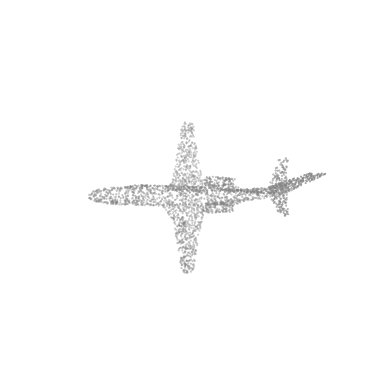

In [ ]:
plot_point_cloud(airplane)

Its rotation:

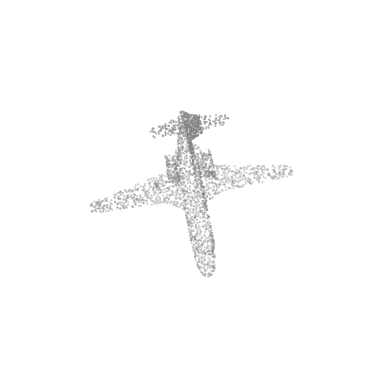

In [ ]:
plot_point_cloud(airplane_rot)

### Applying a function to airplane and its rotation

Apply a function to the point clouds.

In [ ]:
# A simple non-equivariant function. Can try different combination or different functions
def phi(p):
  return (p + 1*airplane +0*airplane2)**2

In [ ]:
f_airplane = phi(airplane)
f_airplane_rot = phi(airplane_rot)

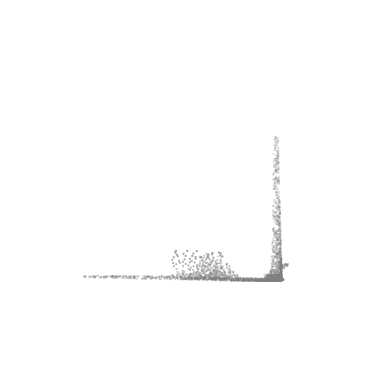

In [ ]:
plot_point_cloud(f_airplane)

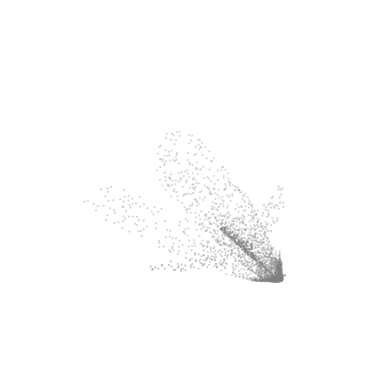

In [ ]:
plot_point_cloud(f_airplane_rot)

Clearly the result is not equivariant!

### PCA on point clouds

Perform PCA on two point clouds.

Airplane:

In [ ]:
principal_directions = getting_principal_directions(airplane)
principal_directions_rot = getting_principal_directions(airplane_rot)

Visualize

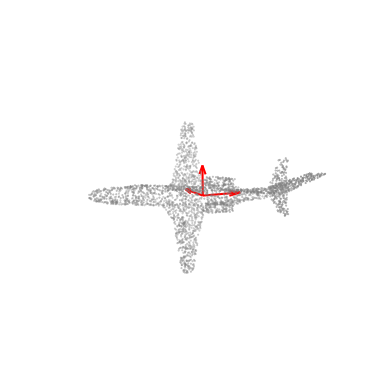

In [ ]:
plot_point_cloud_with_PCA(airplane, principal_directions)

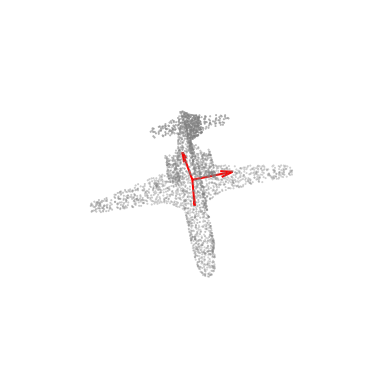

In [ ]:
plot_point_cloud_with_PCA(airplane_rot, principal_directions_rot)

Equivariance of the Frame: The obtained principal directions rotate as the point cloud rotates (under fairly general conditions) up to a sign change (negation of a eigenvector is still a eigenvector).

In [ ]:
print("Principal directions of airplane: \n", principal_directions)
print("Principal directions of rotated airplane: \n", principal_directions_rot)
print("Rotated principal directions of rotated airplane: \n", principal_directions_rot @ R)

Principal directions of airplane: 
 [[-0.82543193  0.56445615  0.00716888]
 [ 0.00939379  0.00103707  0.99995534]
 [ 0.5644235   0.82546241 -0.00615842]]
Principal directions of rotated airplane: 
 [[-0.16929644 -0.81695487 -0.55129253]
 [-0.97132312  0.04355498  0.23373996]
 [ 0.16694347 -0.57505452  0.80090085]]
Rotated principal directions of rotated airplane: 
 [[ 0.82543193 -0.56445615 -0.00716888]
 [-0.00939379 -0.00103707 -0.99995534]
 [-0.5644235  -0.82546241  0.00615842]]


### Frame Averaging

We do frame averaging now:

$$\langle\Phi\rangle_{\mathcal{F}}(x)=\frac{1}{|\mathcal{F}(x)|} \sum_{g \in \mathcal{F}(x)} \rho_2(g) \Phi\left(\rho_1(g)^{-1} x\right)$$

- $\rho_1(g)^{-1}$: Use the principal directions as the bases of a coordinate system to represent the airplane and its rotation.
- $\rho_2(g)$: Go back to the original coordinate system.
- $\frac{1}{|\mathcal{F}(x)|} \sum_{g \in \mathcal{F}(x)}$: Averaging due to sign ambiguity of PCA.

In [ ]:
def FA(point_cloud, principal_directions, f):
  # f is any function, does not have to be equivariant
    frames = getting_frames(principal_directions)
    inverse_frames = np.linalg.inv(frames)
    # using the axes represented by principal vectors -> applying inverse rotation
    rho1_point_cloud = np.einsum('ijk,nk->inj', frames, point_cloud)
    f_rho1_point_cloud = f(rho1_point_cloud)
    rho2_f_rho1_point_cloud = np.einsum('ijk,ink->inj', inverse_frames, f_rho1_point_cloud)
    return np.mean(rho2_f_rho1_point_cloud, axis=0), rho1_point_cloud, f_rho1_point_cloud, rho2_f_rho1_point_cloud

In [ ]:
FA_airplane, rho1_airplane, f_rho1_airplane, rho2_f_rho1_airplane = FA(airplane, principal_directions, phi)
FA_airplane_rot, rho1_airplane_rot, f_rho1_airplane_rot, rho2_f_rho1_airplane_rot = FA(airplane_rot, principal_directions_rot, phi)

The results are indeed equivariant.

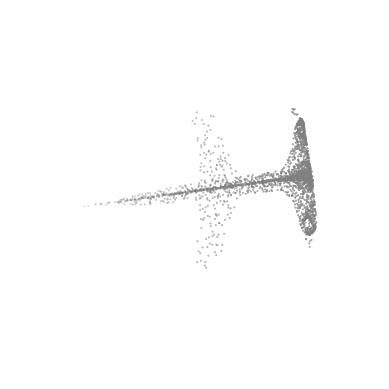

In [ ]:
plot_point_cloud(FA_airplane)

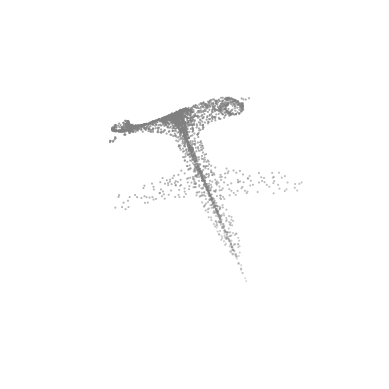

In [ ]:
plot_point_cloud(FA_airplane_rot)

In [ ]:
FA_airplane @ R.T

array([[-0.05381993, -0.32086977, -0.20925776],
       [-0.02222503, -0.1351528 , -0.07571248],
       [-0.04310365, -0.17200308, -0.1147931 ],
       ...,
       [ 0.03421036,  0.00914573, -0.03468398],
       [-0.08220016, -0.3729013 , -0.26266205],
       [-0.04053381, -0.25704082, -0.16891448]])

In [ ]:
FA_airplane_rot

array([[-0.05381993, -0.32086977, -0.20925776],
       [-0.02222503, -0.1351528 , -0.07571248],
       [-0.04310365, -0.17200308, -0.1147931 ],
       ...,
       [ 0.03421036,  0.00914573, -0.03468398],
       [-0.08220016, -0.3729013 , -0.26266205],
       [-0.04053381, -0.25704082, -0.16891448]])

### Why Equivariant?

Let's look at the frame averaging operator again:
$$\langle\Phi\rangle_{\mathcal{F}}(x)=\frac{1}{|\mathcal{F}(x)|} \sum_{g \in \mathcal{F}(x)} \rho_2(g) \Phi\left(\rho_1(g)^{-1} x\right).$$

- $\rho_1(g)^{-1}$: Maps $x$ to the same canonical positions in the orbit. All elements in the group orbit will be mapped to a set of canonical elements, but might be in different orders (permutation).

- $\Phi\left(\rho_1(g)^{-1} x\right)$: The inputs to the function are the same, so we should get the same outputs, up to a permutation.

- $\rho_2(g) \Phi\left(\rho_1(g)^{-1} x\right)$: Maps the outputs to positions in the group orbit informed by the position of $x$ in an equivariant way.
  - The results are equivariant up to a permutation

- $\frac{1}{|\mathcal{F}(x)|} \sum_{g \in \mathcal{F}(x)}$: Averaging to offset the permutation

In [ ]:
# Results should be the same up to a permutation
are_arrays_same(rho1_airplane, rho1_airplane_rot)

True

In [ ]:
are_arrays_same(f_rho1_airplane, f_rho1_airplane_rot)

True

In [ ]:
# If we rotate the results from the airplane, they should be the same up to a permutation
are_arrays_same(rho2_f_rho1_airplane@R.T, rho2_f_rho1_airplane_rot)

True

You can visualize

In [ ]:
# for rep in f_rho1_airplane:
#     plot_point_cloud(rep)

In [ ]:
# for rep in rho2_f_rho1_airplane_rot:
#      plot_point_cloud(rep)

### Expressivity

If the backbone function $\Phi$ is itself equivariant to $G$, then $\langle\Phi\rangle_G = \Phi$ is as expressive as $\Phi$:

$$\begin{aligned}\langle\Phi\rangle_G(x) & =\mathbb{E}_{g \sim \nu} \rho_2(g) \cdot \Phi\left(\rho_1(g)^{-1} \cdot x\right) \\ & =\mathbb{E}_{g \sim \nu} \rho_2(g) \cdot \rho_2(g)^{-1} \cdot \Phi(x) \\ & =\Phi(x)\end{aligned}.$$

In [ ]:
# Define an equivariant function
def rotational_equivariant_phi(point_cloud):
    if len(point_cloud.shape) == 2:  # Single point cloud, shape (n, 3)
        # Compute dot products
        dot_products = point_cloud @ point_cloud.T  # Shape (n, n)
        transformed_dots = np.sinc(dot_products)  # Element-wise non-linearity
        # Aggregation
        aggregated = transformed_dots @ point_cloud  # Shape (n, 3)
    elif len(point_cloud.shape) == 3:  # Batched point clouds, shape (|F|, n, 3)
        # Loop over the batch dimension and apply the same logic as above
        batch_size = point_cloud.shape[0]
        aggregated = np.array([
            rotational_equivariant_phi(single_cloud)  # Apply single cloud logic
            for single_cloud in point_cloud
        ])
    else:
        raise ValueError("Input point_cloud must have shape (n, 3) or (|F|, n, 3).")
    return aggregated

Apply this function to the point clouds

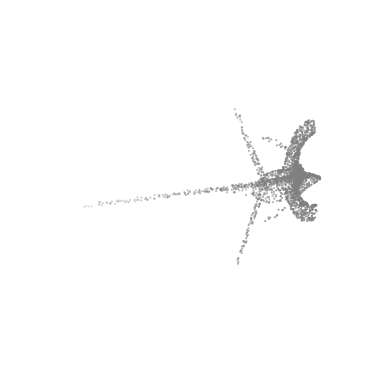

In [ ]:
plot_point_cloud(rotational_equivariant_phi(airplane))

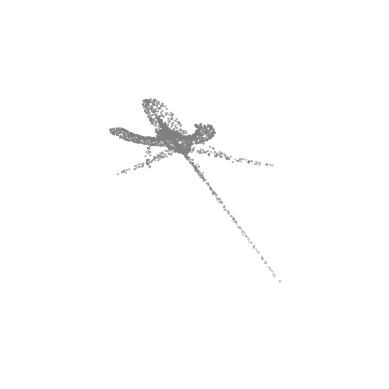

In [ ]:
plot_point_cloud(rotational_equivariant_phi(airplane_rot))

Apply the FA operator, we still get the same outputs

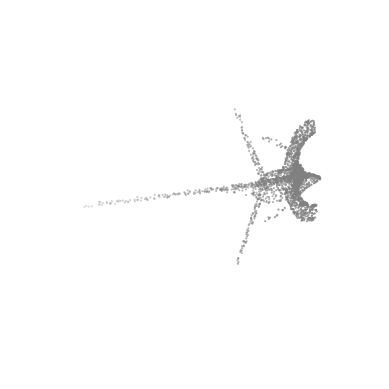

In [ ]:
plot_point_cloud(FA(airplane, principal_directions, rotational_equivariant_phi)[0])

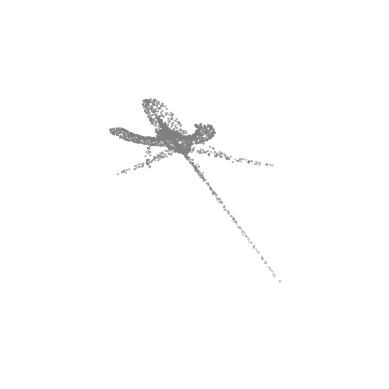

In [ ]:
plot_point_cloud(FA(airplane_rot, principal_directions_rot, rotational_equivariant_phi)[0])